In [378]:
import torch.nn as nn
from torch import optim
import tensorflow as tf
from torch.utils.data import DataLoader
import torch
from torchvision import datasets
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score,f1_score
import torch.functional as F

In [379]:
# image normalization
def normalize_images(imgs):
    return imgs/255.

In [380]:
class Dataset:
    def __init__(self,train_or_test):
        data=datasets.MNIST(root='mnist', download=True,train=train_or_test)
        self.x,self.y=data.data,np.array(data.targets)
        self.x=normalize_images(self.x)
        # self.y=onehot_encoding(self.y)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, item):
        return self.x[item],self.y[item]

In [381]:
# Create a PYTORCH dataset with one-hot encoding + normalization
# (Dataset's labels are already provedided in the appropriate form.)

In [382]:
# loading dataset
train=Dataset(train_or_test=True)
test=Dataset(train_or_test=False)
# answers
test.x[0].size()

torch.Size([28, 28])

In [383]:
# take a view on our dataset
def show_dataset(dataset_,dataset_labels_):
    # to show labels in convenient format
    figure = plt.figure(figsize=(6, 6))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = tf.random.uniform(shape=(1,), minval=0, maxval=len(dataset_), dtype=tf.int64).numpy()[0]
        # retrieve image name and it's labels
        img, label = dataset_[sample_idx],dataset_labels_[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

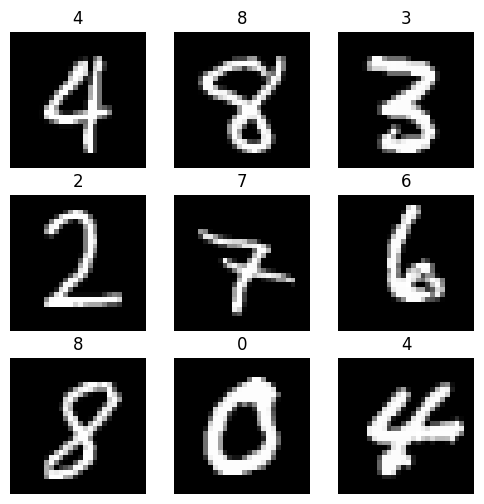

In [384]:
# take a view on dataset
show_dataset(train.x,train.y)

In [385]:
# batch_size=64
train_loader,test_loader=DataLoader(train,shuffle=True),DataLoader(test,shuffle=True)

In [386]:
loss_type=nn.CrossEntropyLoss()

In [387]:
# We have confusion matrix, where it is easy to identify true_positives, false_positives, true negatives.
# True Positives_A: The number of samples correctly classified as class A.
# False Positives_A: The number of samples that are not of class A but are incorrectly classified as class A.(numbers in rows)
# False Negatives_A: The number of samples of class A that are incorrectly classified as not being of class A.(numbers in columns)
# 
# True_positives              False_positives
# 
# False negatives             True negatives

In [388]:
def compute_precision_recall(matrix_):
    y_true,y_pred=[i[0] for i in matrix_],[i[1] for i in matrix_]
    # average = 'macro' => mеtrics are calculated across all classes for entire classification task
    precision=precision_score(y_true=y_true,y_pred=y_pred,average='macro')
    recall=recall_score(y_true=y_true,y_pred=y_pred,average='macro')
    f1_score_=f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    return precision,recall,f1_score_

In [389]:
# drawing Confusion matrix for statistical analysis
def final_matrix(matrix,leng):
    my_matrix=torch.zeros(leng,leng,dtype=torch.int32).tolist()
    # fill the confusion matrix with values
    for i in matrix:
        my_matrix[i[0]][i[1]]+=1
    my_matrix=np.array(my_matrix)
    my_matrix=(my_matrix.T/my_matrix.sum(axis=1)).T
    my_matrix=np.round(my_matrix, 3)
    plt.figure(figsize=(30,36))
    # display matrix in blue colors
    disp = ConfusionMatrixDisplay(confusion_matrix=my_matrix, display_labels=range(10))
    disp.plot(cmap='Blues')
    # save to a folder
    plt.show()

In [390]:
def draw_plots(train_accuracy, test_accuracy, train_loss_, test_loss_):
    # To draw plots of accuracy and loss of train and test datasets
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='blue', linestyle='--',
             label='train accuracy')
    plt.plot(test_accuracy, color='red', linestyle='--',
             label='test accuracy')
    plt.ylabel = 'Accuracy'
    plt.xlabel = 'Epochs' 
    plt.legend()
    plt.show() 
    # Loss plot
    plt.figure(figsize=(10, 7))
    plt.plot(np.array(train_loss_), color='blue', linestyle='--',
             label='train loss')
    plt.plot(np.array(test_loss_), color='red', linestyle='--',
             label='test loss')
    plt.ylabel = 'Loss'     
    plt.xlabel = 'Epochs'   
    plt.legend()
    plt.show()  

In [391]:
from tqdm import tqdm

def training_process(loader, my_model, optimizer, loss):
    # Turn on the training mode
    my_model.train()
    running_correct, epoch_loss = 0, 0

    for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
        # Gradients are reset to zero
        optimizer.zero_grad()
        outputs = my_model(images)
        _, predictions = torch.max(outputs.data, 1)
        loss_val = loss(outputs, labels)
        # Backward pass
        loss_val.backward()
        optimizer.step()

        # Accumulate statistics over the entire epoch
        epoch_loss += loss_val.item()
        running_correct += (labels == predictions).sum().item()

    # Calculate accuracy and average loss for the entire epoch
    accuracy = 100. * (running_correct / len(loader.dataset))
    epoch_loss /= len(loader)

    return epoch_loss, accuracy

In [392]:
def evaluating_perfomance(loader_test,my_model,loss,last_epoch=False):
        with torch.no_grad():
            # variables to draw confusion matrix
            Confusion_list=[]
            running_correct,epoch_loss=0,0
            total=0
        # no updating loss
            for images,labels in loader_test:
                # flatten image to use it in the model
                outputs=my_model(images)        
                # compute loss on test dataset
                loss_val=loss(outputs,labels)
                # compute the loss and divide by the size of test dataset (10000)
                epoch_loss=loss_val/len(loader_test)
                for index,i in enumerate(outputs):
                    # torch.argmax(i) -> from the array of predictions extract the biggest one 
                    if torch.argmax(i)==labels[index]:
                        running_correct+=1
                    total+=1
                _,predicted_labels=torch.max(outputs.data,1)
                # after last epoch prepare data for Confusion matrix and graphs
                if last_epoch:
                    predicted_data=list(zip(labels.tolist(),predicted_labels.tolist()))
                    Confusion_list.extend(predicted_data)
            # if it is the last epoch --> return the list for confusion matrix
            if not last_epoch:
                return epoch_loss,100.*round(running_correct/total,6),[]
            else:
                return epoch_loss,100.*round(running_correct/total,6),Confusion_list

In [410]:
def run_epochs(learning_rate=0.001,epochs=12,model_type=None):
    optimizer=optim.SGD(model_type.parameters(),lr=learning_rate)
    criterion=nn.CrossEntropyLoss()
    train_loss,testing_loss=[],[]
    train_acc,testing_acc=[],[]
    last_epoch=False
    confusion__matrix=[]
    for epoch in range(1,epochs+1):
            if epoch==epochs:
                last_epoch=True
            print(f"Epoch number: {epoch}")
            print()
            print('Training..')
            loss_,accuracy=training_process(loader=train_loader,my_model=model_type,loss=criterion,optimizer=optimizer)
            train_loss.append(loss_)
            train_acc.append(accuracy)
            print(f'Training_Loss: {loss_} and Training_Accuracy: {accuracy} %')
            print('Testing..')
            loss_test,accuracy_test,confusion__matrix=evaluating_perfomance(loader_test=test_loader,my_model=model_type,loss=criterion,last_epoch=last_epoch)
            testing_loss.append(loss_test)
            testing_acc.append(accuracy_test)
            print(f'Testing_Loss: {loss_test} and Testing_Accuracy: {accuracy_test} %')
            print()
            print('-'*80)
            print()
    final_matrix(matrix=confusion__matrix,leng=10)
    train_loss,testing_loss=[float(i) for i in train_loss],[float(i) for i in testing_loss]
    draw_plots(train_accuracy=train_acc,train_loss_=np.array(train_loss),test_loss_=np.array(testing_loss),test_accuracy=testing_acc)
    # call function to compute precision and recall, f1 score
    precision,recall,f1_score_=compute_precision_recall(confusion__matrix)
    return {'precision':precision,'recall':recall,'f1_score':f1_score_,'accuracy':testing_acc[-1],'min_loss':min(testing_loss)}

In [411]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input channel (grey images), 16 output channels, kernel size 3x3, padding = 1 to save dimension of the image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # Max pooling with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        # dimension : 16 x 14 x 14
        # second convolutional layer
        self.conv2=nn.Conv2d(16 , 32,kernel_size=3,stride=1,padding=1)
        # Conv2 + self.pool   => dimension = 32 x 7 x 7
        self.relu=nn.ReLU()
        self.softmax=nn.Softmax()
        # now let's write convolutional layer to implement skip-connection
        self.skip_connection=nn.Conv2d(16, 32,stride=2,kernel_size=1)
         # Fully connected layer
        self.fc1 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        # Apply convolutional layer
        x1 = self.relu(self.conv1(x))
        x_skipped=self.skip_connection(x1)
        # Apply max pooling
        x = self.pool(x1)
        # sum the x with the result of skip-connection layer
        x=self.conv2(x)
        x+=x_skipped
        x=self.pool(x)
        # Reshape the tensor for fully connected layer
        x = x.view(-1, 32 * 7 * 7)
        # Fully connected layer
        x = self.fc1(x)
        return self.softmax(x)


In [412]:
model=Model()
model

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (skip_connection): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

Epoch number: 1

Training..


  0%|          | 0/60000 [00:00<?, ?it/s]/Users/boris/PycharmProjects/Programming/Yandex_liceum/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 60000/60000 [01:14<00:00, 809.30it/s]


Training_Loss: 1.7420765118976433 and Training_Accuracy: 73.76 %
Testing..
Testing_Loss: 0.0002189767110394314 and Testing_Accuracy: 91.38 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [01:12<00:00, 824.48it/s]


Training_Loss: 1.5471562611917655 and Training_Accuracy: 91.92333333333333 %
Testing..
Testing_Loss: 0.00014611543156206608 and Testing_Accuracy: 93.89999999999999 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [01:13<00:00, 820.30it/s]


Training_Loss: 1.5241508363862832 and Training_Accuracy: 94.16666666666667 %
Testing..
Testing_Loss: 0.00014611502410843968 and Testing_Accuracy: 95.22 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [01:13<00:00, 816.89it/s]


Training_Loss: 1.5102779314657053 and Training_Accuracy: 95.48666666666666 %
Testing..
Testing_Loss: 0.0001467594556743279 and Testing_Accuracy: 96.33 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [01:13<00:00, 816.61it/s]


Training_Loss: 1.5015178418894608 and Training_Accuracy: 96.33 %
Testing..
Testing_Loss: 0.00014612490485887975 and Testing_Accuracy: 96.76 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [01:12<00:00, 825.80it/s]


Training_Loss: 1.4959439194599788 and Training_Accuracy: 96.87666666666667 %
Testing..
Testing_Loss: 0.0001461150386603549 and Testing_Accuracy: 97.11999999999999 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [01:02<00:00, 964.77it/s] 


Training_Loss: 1.4917464283963044 and Training_Accuracy: 97.24000000000001 %
Testing..
Testing_Loss: 0.00014611876395065337 and Testing_Accuracy: 97.50999999999999 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [01:02<00:00, 960.28it/s] 


Training_Loss: 1.4886796701729297 and Training_Accuracy: 97.515 %
Testing..
Testing_Loss: 0.00014620096771977842 and Testing_Accuracy: 97.63 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [01:02<00:00, 955.98it/s] 


Training_Loss: 1.4867423295358817 and Training_Accuracy: 97.67833333333333 %
Testing..
Testing_Loss: 0.0001461167703382671 and Testing_Accuracy: 97.6 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [01:02<00:00, 961.90it/s] 


Training_Loss: 1.4850975260357062 and Training_Accuracy: 97.83500000000001 %
Testing..
Testing_Loss: 0.00014611694496124983 and Testing_Accuracy: 97.92 %

--------------------------------------------------------------------------------

Epoch number: 11

Training..


100%|██████████| 60000/60000 [01:01<00:00, 975.81it/s] 


Training_Loss: 1.4836814843177795 and Training_Accuracy: 97.96833333333333 %
Testing..
Testing_Loss: 0.0001461153879063204 and Testing_Accuracy: 98.0 %

--------------------------------------------------------------------------------

Epoch number: 12

Training..


100%|██████████| 60000/60000 [01:00<00:00, 988.68it/s] 


Training_Loss: 1.4821166598220665 and Training_Accuracy: 98.13833333333334 %
Testing..
Testing_Loss: 0.00014611502410843968 and Testing_Accuracy: 98.08 %

--------------------------------------------------------------------------------


<Figure size 3000x3600 with 0 Axes>

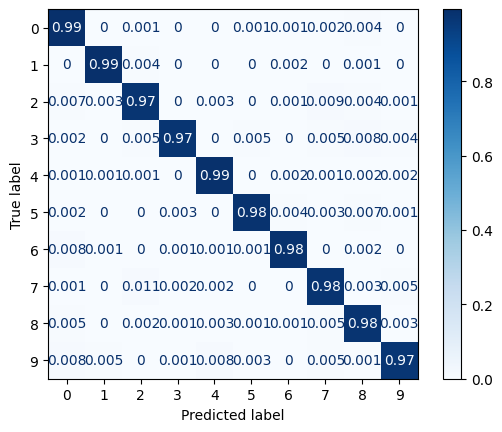

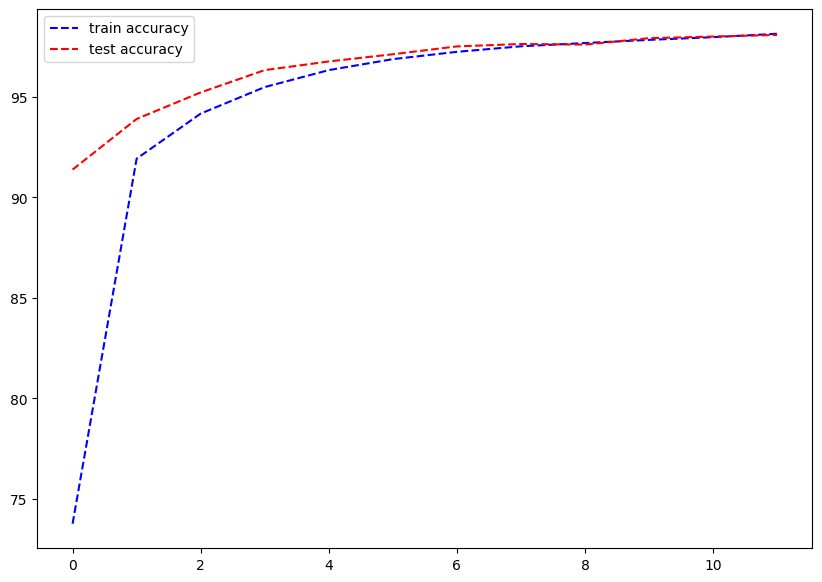

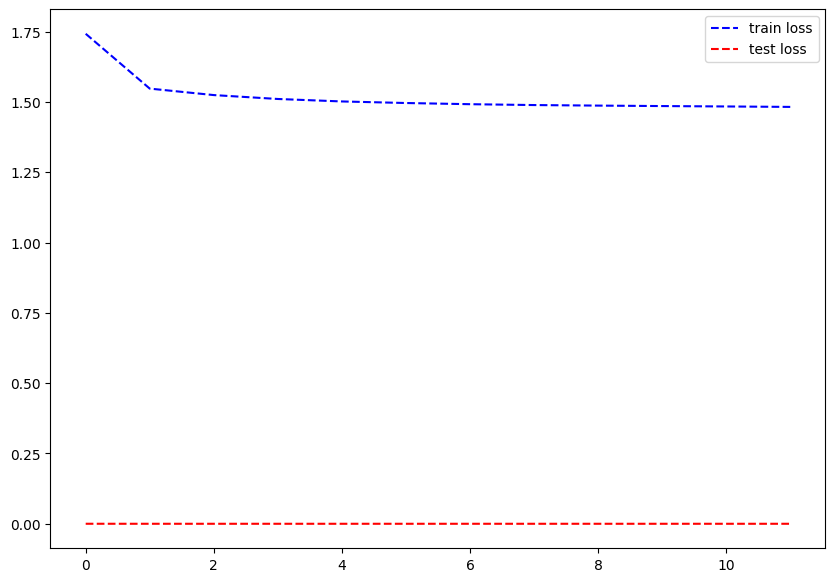

{'precision': 0.9808181498169668, 'recall': 0.9807076377838368, 'f1_score': 0.9807236773471493, 'accuracy': 98.08, 'min_loss': 0.00014611502410843968}


In [413]:
scores = run_epochs(model_type=model)
print(scores)

In [414]:
model

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (skip_connection): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)